In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
import re


C:\apps\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
### Movie Information Dataset

file_path = './data/' + 'movies.csv'
df_movie = pd.read_csv(file_path)
df_movie.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
### Movie Rating Dataset

file_path = './data/' + 'ratings.csv'
df_rating = pd.read_csv(file_path)
df_rating.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
### Movie Genre List

genre_full = df_movie['genres'].str.split('|').tolist()
genre_list = []

for genre_single in genre_full:
    for ix in genre_single:
        genre_list.append(ix)

genre_list = list(set(genre_list))
genre_list.remove('(no genres listed)')
genre_list


['Comedy',
 'Drama',
 'Horror',
 'Animation',
 'Romance',
 'Mystery',
 'Thriller',
 'Crime',
 'IMAX',
 'Children',
 'Action',
 'Fantasy',
 'Western',
 'Musical',
 'Adventure',
 'Documentary',
 'Sci-Fi',
 'Film-Noir',
 'War']

In [6]:
### Generate Rating By Genres

cols = ['movieId', 'genres']
df_rating = df_rating.merge(df_movie[cols], on='movieId', how='left')

def filterGenre(word, strings):
    if re.search(word, strings):
        val_return = 1
    else:
        val_return = None
    return val_return

for ix in genre_list:
    val = df_rating.apply(lambda x: filterGenre(ix, x['genres']), axis=1)
    df_rating[ix] = val * df_rating['rating']

df_rating.head(15)


,userId,movieId,rating,timestamp,genres,Comedy,Drama,Horror,Animation,Romance,...,Children,Action,Fantasy,Western,Musical,Adventure,Documentary,Sci-Fi,Film-Noir,War
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,4.0,NaN,NaN,4.0,NaN,...,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,1,3,4.0,964981247,Comedy|Romance,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,6,4.0,964982224,Action|Crime|Thriller,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,47,5.0,964983815,Mystery|Thriller,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,50,5.0,964982931,Crime|Mystery|Thriller,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,70,3.0,964982400,Action|Comedy|Horror|Thriller,3.0,NaN,3.0,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,101,5.0,964980868,Adventure|Comedy|Crime|Romance,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
7,1,110,4.0,964982176,Action|Drama|War,NaN,4.0,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
8,1,151,5.0,964984041,Action|Drama|Romance|War,NaN,5.0,NaN,NaN,5.0,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
9,1,157,5.0,964984100,Comedy|War,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [7]:
### Aggregate Genres Rating By User ID

df_matrix = df_rating.groupby(['userId'])[genre_list].mean().fillna(0)
df_matrix.head(10)


,Comedy,Drama,Horror,Animation,Romance,Mystery,Thriller,Crime,IMAX,Children,Action,Fantasy,Western,Musical,Adventure,Documentary,Sci-Fi,Film-Noir,War
userId,,,,,,,,,,,,,,,,,,,
1,4.277108,4.529412,3.470588,4.689655,4.307692,4.166667,4.145455,4.355556,0.000000,4.547619,4.322222,4.297872,4.285714,4.681818,4.388235,0.000000,4.225000,5.00,4.500000
2,4.000000,3.882353,3.000000,0.000000,4.500000,4.000000,3.700000,3.800000,3.750000,0.000000,3.954545,0.000000,3.500000,0.000000,4.166667,4.333333,3.875000,0.00,4.500000
3,1.000000,0.750000,4.687500,0.500000,0.500000,5.000000,4.142857,0.500000,0.000000,0.500000,3.571429,3.375000,0.000000,0.500000,2.727273,0.000000,4.200000,0.00,0.500000
4,3.509615,3.483333,4.250000,4.000000,3.379310,3.478261,3.552632,3.814815,3.000000,3.800000,3.320000,3.684211,3.800000,4.000000,3.655172,4.000000,2.833333,4.00,3.571429
5,3.466667,3.800000,3.000000,4.333333,3.090909,4.000000,3.555556,3.833333,3.666667,4.111111,3.111111,4.142857,3.000000,4.400000,3.250000,0.000000,2.500000,0.00,3.333333
6,3.370079,3.614286,3.263158,4.071429,3.614286,3.733333,3.544118,3.285714,4.666667,3.617021,3.609375,3.538462,3.818182,4.166667,3.893617,0.000000,3.476190,2.50,3.583333
7,3.163265,3.131579,4.000000,3.392857,2.650000,3.178571,3.430233,3.307692,2.454545,3.200000,3.257812,3.065217,1.500000,3.666667,3.314815,0.000000,3.154762,3.25,3.291667
8,3.208333,3.789474,4.500000,5.000000,3.500000,4.000000,3.750000,3.888889,4.500000,4.250000,3.333333,3.250000,3.000000,5.000000,3.545455,0.000000,3.250000,0.00,3.666667
9,3.666667,3.428571,1.800000,4.000000,3.166667,4.000000,2.545455,3.142857,3.000000,4.000000,3.125000,5.000000,4.000000,3.000000,3.800000,0.000000,3.000000,4.00,3.500000


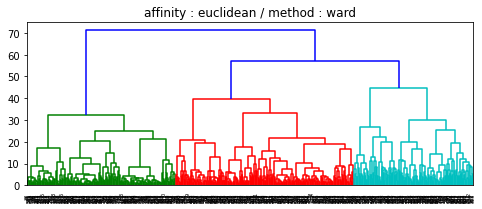

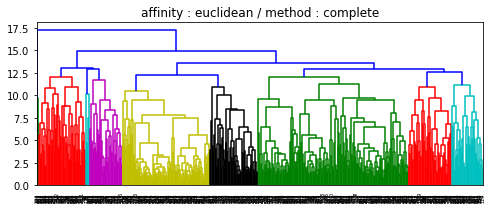

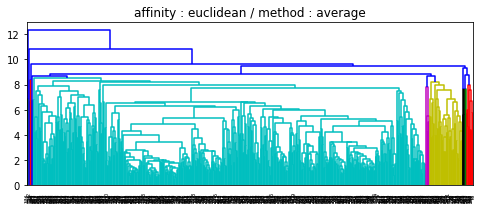

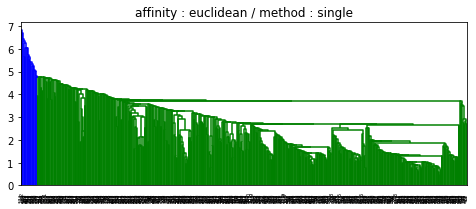

In [8]:
### Dendrogram : Euclidean

aug_affinity = 'euclidean'
aug_methods = ['ward', 'complete', 'average', 'single']

for aug_method in aug_methods:
    plt.figure(figsize=(8, 3))
    plt.title('affinity : {} / method : {}'.format(aug_affinity, aug_method))
    hier_link = sch.linkage(df_matrix, metric=aug_affinity, method=aug_method)
    hier_dend = sch.dendrogram(hier_link)
    plt.show()


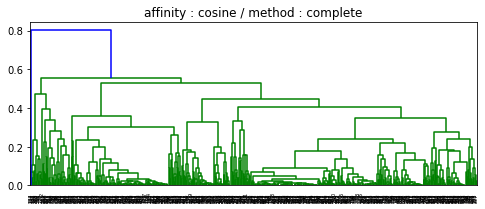

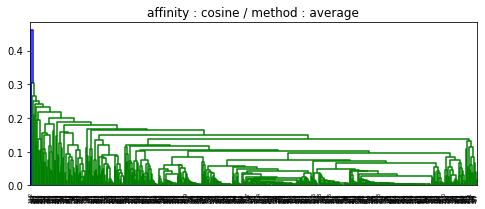

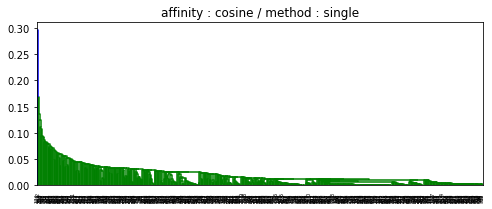

In [9]:
### Dendrogram : Cosine

aug_affinity = 'cosine'
aug_methods = ['complete', 'average', 'single']

for aug_method in aug_methods:
    plt.figure(figsize=(8, 3))
    plt.title('affinity : {} / method : {}'.format(aug_affinity, aug_method))
    hier_link = sch.linkage(df_matrix, metric=aug_affinity, method=aug_method)
    hier_dend = sch.dendrogram(hier_link)
    plt.show()


In [10]:
### Clustering

n_cluster = 3
array_matrix = df_matrix.values
aug1 = 'euclidean'
aug2 = 'ward'

clustering = AgglomerativeClustering(n_clusters=n_cluster,
                                     affinity=aug1, linkage=aug2)

array_cluster = clustering.fit_predict(array_matrix)
df_matrix['cluster'] = array_cluster
df_matrix.head(10)


,Comedy,Drama,Horror,Animation,Romance,Mystery,Thriller,Crime,IMAX,Children,Action,Fantasy,Western,Musical,Adventure,Documentary,Sci-Fi,Film-Noir,War,cluster
userId,,,,,,,,,,,,,,,,,,,,
1,4.277108,4.529412,3.470588,4.689655,4.307692,4.166667,4.145455,4.355556,0.000000,4.547619,4.322222,4.297872,4.285714,4.681818,4.388235,0.000000,4.225000,5.00,4.500000,1
2,4.000000,3.882353,3.000000,0.000000,4.500000,4.000000,3.700000,3.800000,3.750000,0.000000,3.954545,0.000000,3.500000,0.000000,4.166667,4.333333,3.875000,0.00,4.500000,2
3,1.000000,0.750000,4.687500,0.500000,0.500000,5.000000,4.142857,0.500000,0.000000,0.500000,3.571429,3.375000,0.000000,0.500000,2.727273,0.000000,4.200000,0.00,0.500000,0
4,3.509615,3.483333,4.250000,4.000000,3.379310,3.478261,3.552632,3.814815,3.000000,3.800000,3.320000,3.684211,3.800000,4.000000,3.655172,4.000000,2.833333,4.00,3.571429,1
5,3.466667,3.800000,3.000000,4.333333,3.090909,4.000000,3.555556,3.833333,3.666667,4.111111,3.111111,4.142857,3.000000,4.400000,3.250000,0.000000,2.500000,0.00,3.333333,2
6,3.370079,3.614286,3.263158,4.071429,3.614286,3.733333,3.544118,3.285714,4.666667,3.617021,3.609375,3.538462,3.818182,4.166667,3.893617,0.000000,3.476190,2.50,3.583333,1
7,3.163265,3.131579,4.000000,3.392857,2.650000,3.178571,3.430233,3.307692,2.454545,3.200000,3.257812,3.065217,1.500000,3.666667,3.314815,0.000000,3.154762,3.25,3.291667,1
8,3.208333,3.789474,4.500000,5.000000,3.500000,4.000000,3.750000,3.888889,4.500000,4.250000,3.333333,3.250000,3.000000,5.000000,3.545455,0.000000,3.250000,0.00,3.666667,2
9,3.666667,3.428571,1.800000,4.000000,3.166667,4.000000,2.545455,3.142857,3.000000,4.000000,3.125000,5.000000,4.000000,3.000000,3.800000,0.000000,3.000000,4.00,3.500000,1


In [11]:
### Aggregate By Clusters

cols = ['cluster']
cols_val = df_matrix.columns.tolist()[:-1]
df_agg = df_matrix.groupby(cols)[cols_val].mean()
df_agg


,Comedy,Drama,Horror,Animation,Romance,Mystery,Thriller,Crime,IMAX,Children,Action,Fantasy,Western,Musical,Adventure,Documentary,Sci-Fi,Film-Noir,War
cluster,,,,,,,,,,,,,,,,,,,
0,3.486066,3.690486,2.652243,1.997386,3.481222,3.231082,3.554623,3.640075,0.925042,2.266656,3.478705,3.089670,1.703304,1.933531,3.484506,0.707596,3.423215,0.848160,2.667971
1,3.534633,3.747375,3.374224,3.584476,3.599273,3.706991,3.593490,3.747621,3.262343,3.424474,3.494951,3.571803,3.127828,3.366958,3.555571,2.641126,3.477337,3.813076,3.852511
2,3.635635,3.808980,2.997225,3.545179,3.717232,3.693722,3.681370,3.737451,3.812193,3.631895,3.630562,3.495561,2.529759,2.821950,3.698616,0.784609,3.578609,0.031762,3.753026


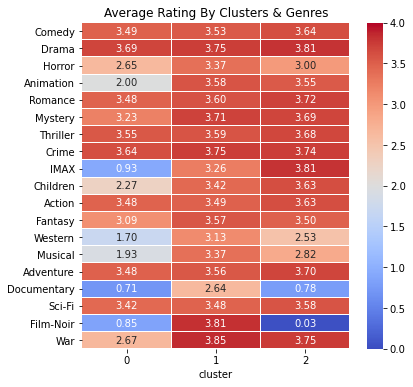

In [21]:
### Heatmap : Aggregate By Clusters

plt.figure(figsize=(6, 6))
sns.heatmap(df_agg.T, cmap='coolwarm', vmax=4, vmin=0, linewidths=.01, annot=True, fmt='.2f')
plt.title('Average Rating By Clusters & Genres', fontsize=12)
plt.show()


In [23]:
### Count UserID By Clusters With Rating Bins

v1 = -.0000000001
df_agg = DataFrame()

for ix in genre_list:
    df_temp = df_matrix[['cluster', ix]].copy()
    df_temp['bin'] = pd.cut(df_temp[ix], 
                            bins=[0+v1, 1+v1, 2+v1, 3+v1, 4+v1, 5+v1, 6+v1],
                            labels=[0, 1, 2, 3, 4, 5], include_lowest=False)
    cols = ['cluster', 'bin']
    df_agg_temp = df_temp.groupby(cols).agg({ix:'count'})
    df_agg = pd.concat([df_agg, df_agg_temp], axis=1)

df_agg.fillna(0, inplace=True)
df_agg


Comedy  Drama  Horror  Animation  Romance  Mystery  Thriller  \
cluster bin                                                                 
0       0         1      1      37         70        5       22         2   
        1         4      3       6          6        4        2         5   
        2        24     13      22         12       22       11        23   
        3        99     87      58         34       74       64        83   
        4        34     58      32         35       54       53        49   
        5         1      1       8          6        4       11         1   
1       0         0      0       4          4        0        0         0   
        1         0      0       5          2        1        0         0   
        2        24     14      39         23       24       15        22   
        3       154    129     107        113      138      124       135   
        4        25     60      47         60       40       64        46   
        5         0      0       1          1        0        0         0   
2       0         0      0      41         15        1       10         1   
        1         1      1       7          2        3        3         4   
        2        23     10      33         18       16       18        19   
        3       156    142      83        102      135       92       145   
        4        61     90      63         95       79       97        72   
        5         3      1      17         12       10       24         3   

             Crime  IMAX  Children  Action  Fantasy  Western  Musical  \
cluster bin                                                             
0       0        7   124        49       5       18       86       75   
        1        2     3        13       4        8        3        4   
        2       14     3        19      22       23       10       12   
        3       65     9        44      86       67       24       31   
        4       71    14        33      44       38       33       33   
        5        4    10         5       2        9        7        8   
1       0        0    23         3       0        0       29       14   
        1        0     3         6       2        1        4        1   
        2       16    18        31      27       24       22       23   
        3      126    92       109     146      133       82      108   
        4       61    60        53      28       44       61       55   
        5        0     7         1       0        1        5        2   
2       0        3     7         3       0        9       77       57   
        1        3     0         0       1        4        0        1   
        2       13    14        23      22       22       16       18   
        3      125    91       127     154      131       76       93   
        4       96   101        83      66       73       61       61   
        5        4    31         8       1        5       14       14   

             Adventure  Documentary  Sci-Fi  Film-Noir  War  
cluster bin                                                  
0       0            5          132       6        127   52  
        1            5            3      10          1    2  
        2           22            1      23          1   10  
        3           77            9      65         14   29  
        4           49           14      56         13   51  
        5            5            4       3          7   19  
1       0            0           62       0          5    1  
        1            1            2       0          2    0  
        2           24           11      28          8    8  
        3          146           57     147         74  104  
        4           31           62      27        100   86  
        5            1            9       1         14    4  
2       0            0          194       2        239    8  
        1            0            2       0          4    5  
        2          

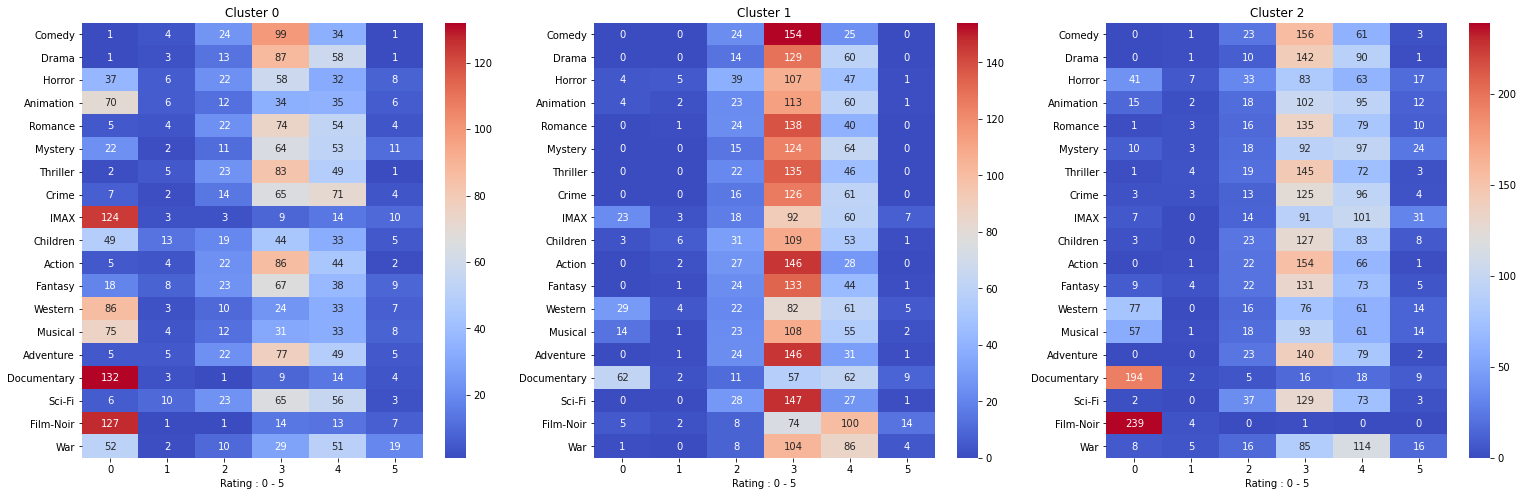

In [35]:
### Heatmap : Aggregate By Clusters With Rating Bins

fig, ax = plt.subplots(1, 3, figsize=(26, 8))

for ix in range(3):
    sns.heatmap(df_agg.loc[ix].T, cmap='coolwarm', ax=ax[ix], annot=True, fmt='d')
    ax[ix].set_title('Cluster {}'.format(ix), fontsize=12)
    ax[ix].set_xlabel('Rating : 0 - 5')

plt.show()
